## Smart campaign - ruin stop

In this campaign we are going to implement:
- Rolling median alpha switching off


This conept is based on splitted RiskReversal Alphas


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
CAMPAIGN_DICT = {
    'name': "SmartCampaign_RuinStop_Concept",
    
    # Allowed values for both ALPHA_RISK_TYPE and CAMPAIGN_RISK_TYPE

    # 'atr' - ATR(RISK_PERIOD) of alpha/campaign equity risk metric
    # 'atrmax' - Highest(ATR(RISK_PERIOD)) of alpha/campaign equity risk metric
    # 'ddavg' - rolling mean (RISK_PERIOD) of drawdown of alpha/campaign equity 
    # 'ddmax' - rolling maximum (RISK_PERIOD) of drawdown of alpha/campaign equity
    # 'ddq95' - rolling 95% quantile (RISK_PERIOD) of drawdown of alpha/campaign equity        
    'alpha_risk_type': 'atr',
    'alpha_risk_period': 100,
    'alpha_min_risk': 100,

    'campaign_risk_type': 'atrmax',
    'campaign_risk_period': 100,
    'campaign_min_risk': 100,
    
    'ruinstop_mean_period': 100,
    
    # We can use any weight for ruined alpha (for example 0.3 or 0.5) to keep some part of this alpha
    'ruined_alpha_weight': 0.0,
    
    #
    # Campaign definition
    #
    'alphas': {    
        '6C_ContFut_Long_Strategy_DSP_LPBP_Combination__Bullish_Sept_15_custom': {'tag': ''},
        '!NEW_AlphaV1Exposure_HedgedBy_V2_US_6C_EXOSemiFuture_DynKel_20_80_longs_DSP_LPBP_Combination__Bullish_Sept_15_Oct_17': {'tag': ''},        
    }
}

### Loading smart campaign alphas

In [4]:
import pandas as pd
from smartcampaign import SmartCampaignBase
from smartcampaign.tools import *
import os

#
# Init V1 framework datasource
#
from exobuilder.data.exostorage import EXOStorage
from scripts.settings import *

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)



# Loading V1 and V2 alphas
alphas_list = SmartCampaignBase.get_alphas_list_from_settings(CAMPAIGN_DICT)
alphas_series_dict = storage.swarms_data(alphas_list, load_v2_alphas=True)
df_alphas_equities = pd.DataFrame({k: v['swarm_series']['equity'] for k,v in alphas_series_dict.items()})


## Creating customized SmartCampaign

There are 3 main methods for SmartCampaign customization
- calc_alpha_risk(...) - calculates the risk of a particucular alpha equity in dollars
- compose_portfolio(...) - allows you to manage portfolio of alphas, by shutting down or managing alpha weights
- calc_campaign_risk(...) - calculates custom campaign risk 

In [5]:
class SmartCampaignCustom(SmartCampaignBase):    
    def calc_alpha_risk(self, alpha_equity):
        """
        Perform calculation of single alpha risk
        :param alpha_equity: alpha equity series
        :return: risk adjusted alpha equity series
        """
        # Note: CAMPAIGN_DICT values are available via self._cmp_dict
        
        # Use default method of SmartCampaignBase.calc_alpha_risk()
        return super().calc_alpha_risk(alpha_equity)
        
    def compose_portfolio(self, df_adj_alpha_equity: pd.DataFrame) -> dict:
        """
        Main portfolio composition method (by default it returns all alphas with weight 1.0)
        :param df_adj_alpha_equity: Risk adjusted equity dataframe
        :return: dict[alpha_name: adj_alpha_size]                
        """
        
        ruin_stop_period = self._cmp_dict['ruinstop_mean_period']
        ruined_alpha_weight = self._cmp_dict['ruined_alpha_weight']
        
        mean_eq = df_adj_alpha_equity.rolling(ruin_stop_period).median()
        
        result_dict = {}
        
        for alpha_name in mean_eq:            
            if df_adj_alpha_equity[alpha_name][-1] >= mean_eq[alpha_name][-1]:
                # Keep alphas with equities >= rolling median()
                result_dict[alpha_name] = 1.0
            else:
                # Otherwize decrease the size 
                result_dict[alpha_name] = ruined_alpha_weight
                
        return result_dict
                
        
        # Use default method of SmartCampaignBase.compose_portfolio()
        #return super().compose_portfolio(df_adj_alpha_equity)
        
        
    def calc_campaign_risk(self, adj_campaign_equity) -> float:
        """
        Perform estimation of campaign risk
        :param adj_campaign_equity: cumulative campaign equity of composed alphas with adjusted weights
        :return: the estimated risk of campaign composition (float number)
        """ 
        # Note: CAMPAIGN_DICT values are available via self._cmp_dict
        
        # Use default method of SmartCampaignBase.calc_campaign_risk()
        return super().calc_campaign_risk(adj_campaign_equity)
        

In [6]:
scmp = SmartCampaignCustom(CAMPAIGN_DICT, df_alphas_equities)

In [7]:
scmp.compose_portfolio(scmp.equities)

{'!NEW_AlphaV1Exposure_HedgedBy_V2_US_6C_EXOSemiFuture_DynKel_20_80_longs_DSP_LPBP_Combination__Bullish_Sept_15_Oct_17': 0.0,
 '6C_ContFut_Long_Strategy_DSP_LPBP_Combination__Bullish_Sept_15_custom': 0.0}

# Backtesting

In [8]:
#
# Init Smart Campaign
#
import datetime


BACKTESTER_SETTINGS = {
    'start_date': datetime.datetime(2014, 1, 1),
    'initial_capital': 50000,
    'target_risk_percent': 0.01,    
}

bt_dict = scmp.backtest(**BACKTESTER_SETTINGS)

NetProfit $                      9553.16
NetProfit %                        19.11%

MaxDD $                        -18890.78
MaxDD %                           -36.66%

MaxATR $                          684.68
Q95% ATR $                        657.19
Avg ATR $                         569.92

MaxATR %                            1.20%
Q95% ATR %                          1.12%
Avg ATR %                           0.98%


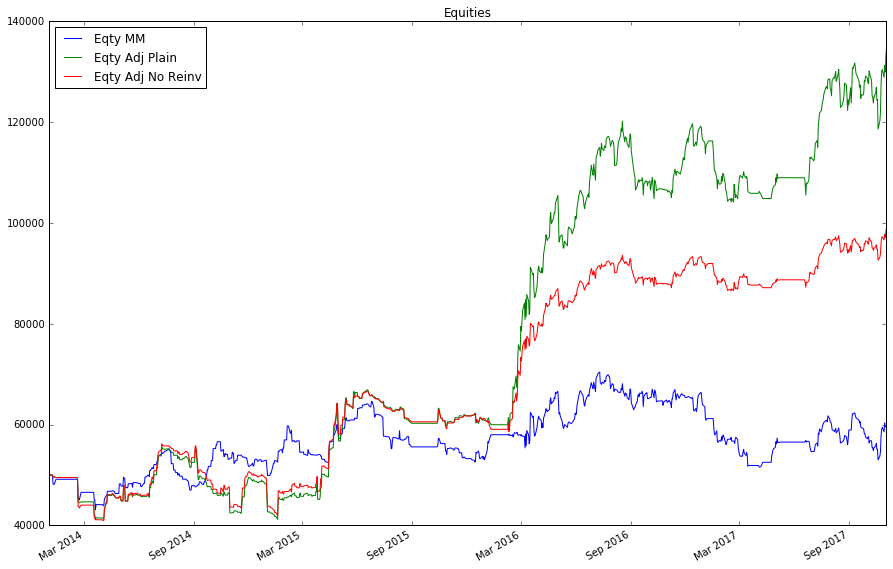

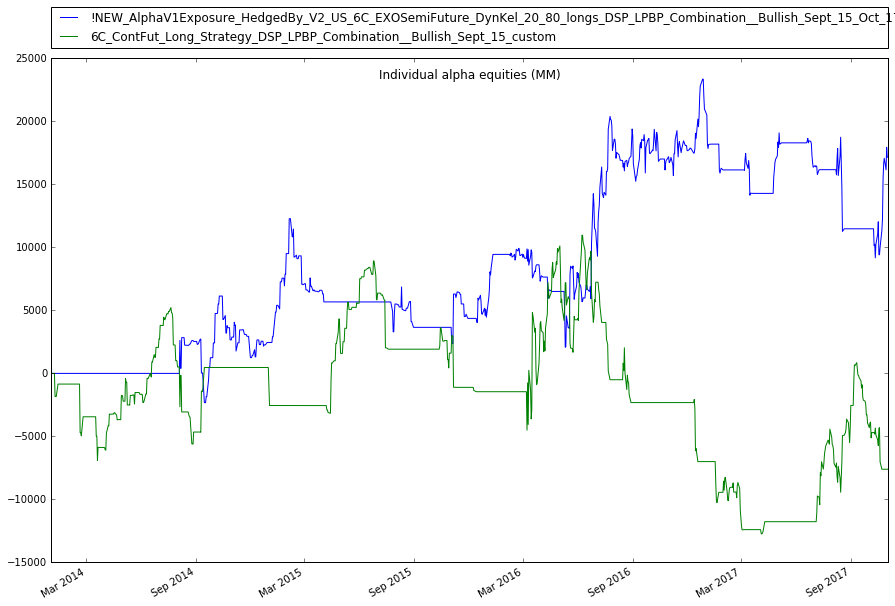

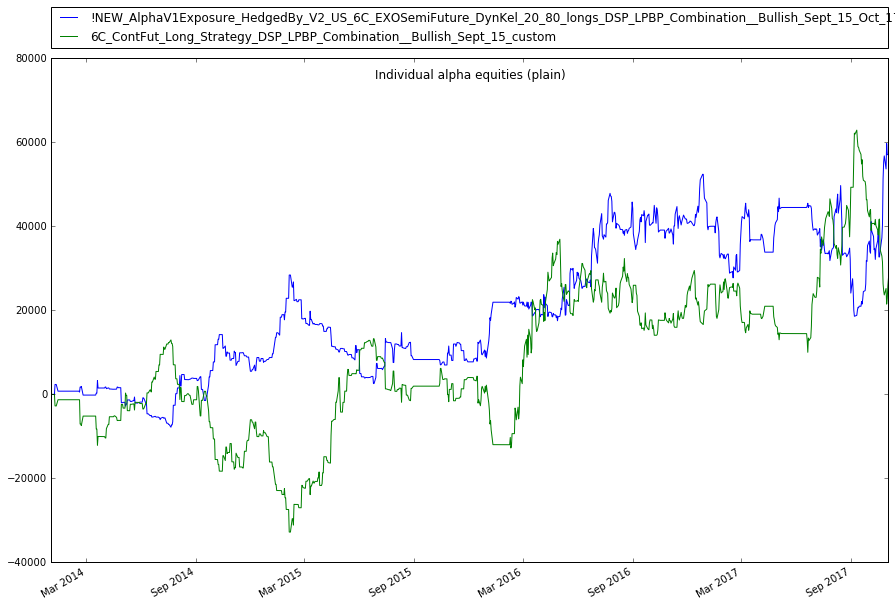

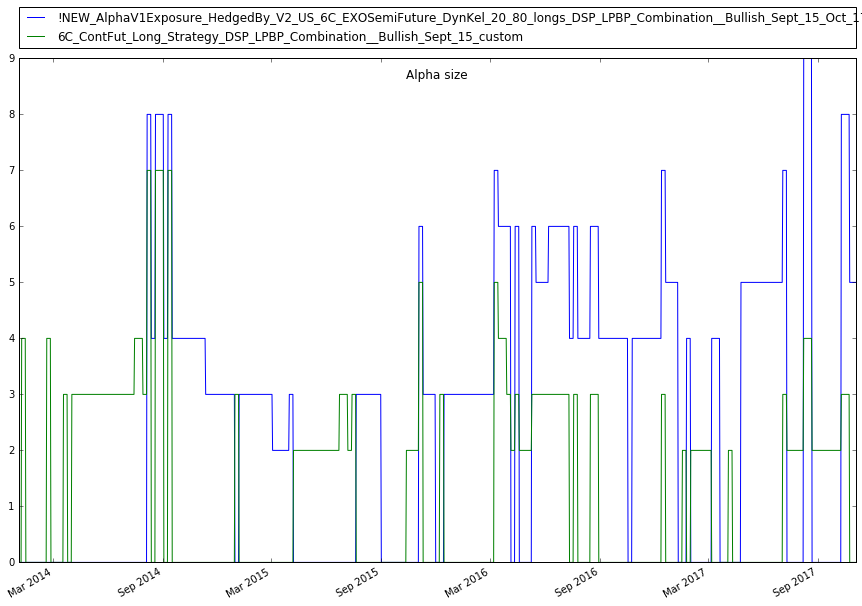

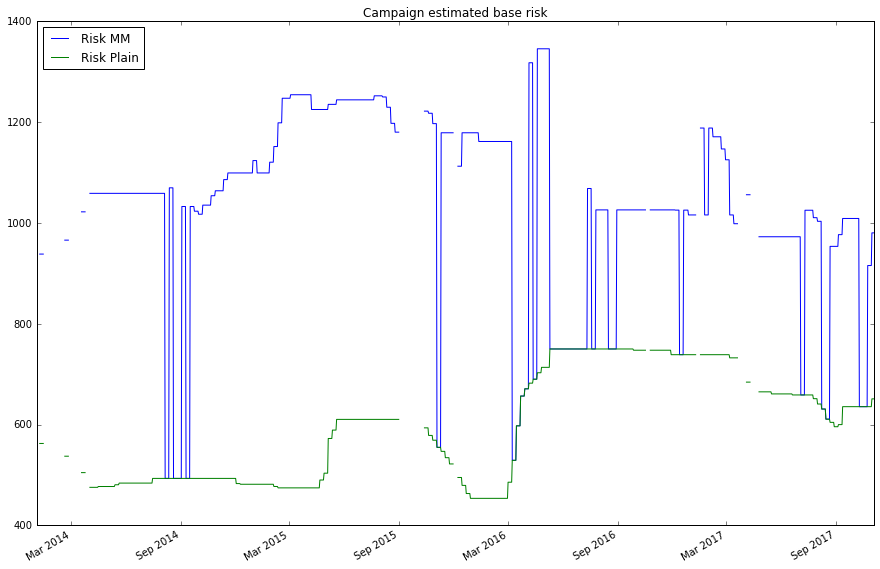

In [9]:
figsize(15, 10)
scmp.report(bt_dict)